# ECG Heartbeat Categorization with B-Splines

We will use B-splines to extract features from this high dimensional dataset and use it for classification.

Number of features available is large compared to available number of samples for most classes. B-splines dimensionality reduction technique will be used to improve curse of dimensionality. 

Below models will be compared with and without B-splines:

* Logistic Regression
* KNN
* Naive Bayes 
* SVC

We also note that this is an imbalanced dataset. Most classes except for the base class "normal" does not have high representation. This will also be tried to be improved using re-sampling. 

B-splines can be used to smooth functional data (where signal changes over time or space). In our case, ECG signals change over time and we can use B-splines to get a smooth estimation of the signals, and reduce dimension of the data.

Refer to "Exploratory Data Analysis" notebook for more details about the dataset.

In [3]:
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import patsy

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
train = pd.read_csv("data/mitbih_train.csv", header = None)
test = pd.read_csv("data/mitbih_test.csv", header = None)

# Last column reserved for classes
X_train = train.iloc[:, :-1].to_numpy()
y_train = train.iloc[:, -1].to_numpy().astype(int)

X_test = test.iloc[:, :-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().astype(int)

In [5]:
X_test.shape

(21892, 187)

In [6]:
X_train.shape

(87554, 187)

### Class Imbalance: 

Not enough samples from each class. We'll randomly re-sample to a larger size for the least represented classes, and down sample the largest.

In [7]:
train.iloc[:, -1].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

In [8]:
sample_size = 15000

df_1 = train[y_train == 1]
df_2 = train[y_train == 2]
df_3 = train[y_train == 3]
df_4 = train[y_train == 4]
df_0 = (train[y_train == 0]).sample(n = sample_size, random_state = 0) # Down-sample.

df_1 = resample(df_1, replace = True, n_samples = sample_size, random_state = 1)
df_2 = resample(df_2, replace = True, n_samples = sample_size, random_state = 2)
df_3 = resample(df_3, replace = True, n_samples = sample_size, random_state = 3)
df_4 = resample(df_4, replace = True, n_samples = sample_size, random_state = 4)

train = pd.concat([df_0, df_1, df_2, df_3, df_4])

X_train = train.iloc[:, :-1].to_numpy()
y_train = train.iloc[:, -1].to_numpy().astype(int)

In [9]:
class_names = [
    "Normal Beat",
    "Supraventricular Premature Beat", 
    "Premature Ventricular Contraction",
    "Fusion of Ventricular and Normal Beat",
    "Unclassifiable Beat"
    ]

#### MinMax scaling was found to work better compared to standard scaling

In [10]:
# MinMax Scale:
X_train_minmax = MinMaxScaler().fit_transform(X_train)
X_test_minmax = MinMaxScaler().fit_transform(X_test)

# Standard Scale:
X_train_sscale = StandardScaler().fit_transform(X_train)
X_test_sscale = StandardScaler().fit_transform(X_test)

#### B-Spline Dimensionality Reduction:

$\widehat{f} = B(B^{T}B)^{-1}B^{T}y=Hy$

Where $\widehat{f}$ is a smooth estimation of signal $y$ and $H$ is the smoother matrix.

In [11]:
x = np.linspace(0,1, X_train.shape[1])
M = 4 # Order
K = 11 # Knots
spb = K + 2 # spline basis
k = np.linspace(0, 1, spb) # knots
k = k[1:(len(k) - 1)] # Excluding end points
nbasis = K + M - 2 + 2 # Due to exclusion of end points, add + 2 to calculate nbasis

B = patsy.bs(x,  knots = k, degree = M - 1, include_intercept = True) # B-spline basis

H = np.linalg.inv(B.T @ B) @ B.T # Smoother matrix, found using least squares method.

# Get B-spline coefficients for train and test:
Bcoef_train = np.zeros((X_train.shape[0], nbasis))

for i in range(X_train.shape[0]):
    Bcoef_train[i, :] =  H @ X_train[i, :].T
    
Bcoef_test = np.zeros((X_test.shape[0], nbasis))

for i in range(X_test.shape[0]):
    Bcoef_test[i, :] = H @ X_test[i, :].T

In [12]:
# MinMax Scale:
Bcoef_train_minmax = MinMaxScaler().fit_transform(Bcoef_train)
Bcoef_test_minmax = MinMaxScaler().fit_transform(Bcoef_test)

# Standard Scale:
Bcoef_train_sscale = StandardScaler().fit_transform(Bcoef_train)
Bcoef_test_sscale = StandardScaler().fit_transform(Bcoef_test)

### Logistic Regression:

#### Without B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.97      0.63      0.77     18118
      Supraventricular Premature Beat       0.14      0.67      0.23       556
    Premature Ventricular Contraction       0.29      0.73      0.42      1448
Fusion of Ventricular and Normal Beat       0.08      0.87      0.15       162
                  Unclassifiable Beat       0.73      0.92      0.81      1608

                             accuracy                           0.66     21892
                            macro avg       0.44      0.76      0.48     21892
                         weighted avg       0.88      0.66      0.73     21892



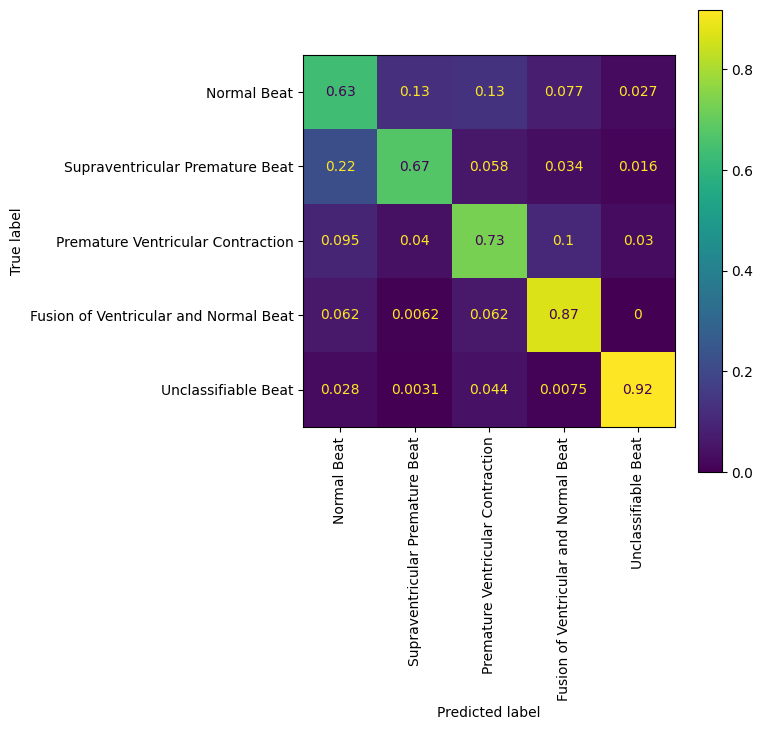

33.60459542274475 seconds


In [13]:
start_time = time.time()
model = LogisticRegression(multi_class = "multinomial", max_iter = 1000)
model.fit(X_train_minmax, y_train)
y_pred = model.predict(X_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

#### With B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.93      0.86      0.90     18118
      Supraventricular Premature Beat       0.15      0.25      0.19       556
    Premature Ventricular Contraction       0.37      0.49      0.42      1448
Fusion of Ventricular and Normal Beat       0.11      0.69      0.19       162
                  Unclassifiable Beat       0.90      0.71      0.80      1608

                             accuracy                           0.81     21892
                            macro avg       0.49      0.60      0.50     21892
                         weighted avg       0.87      0.81      0.84     21892



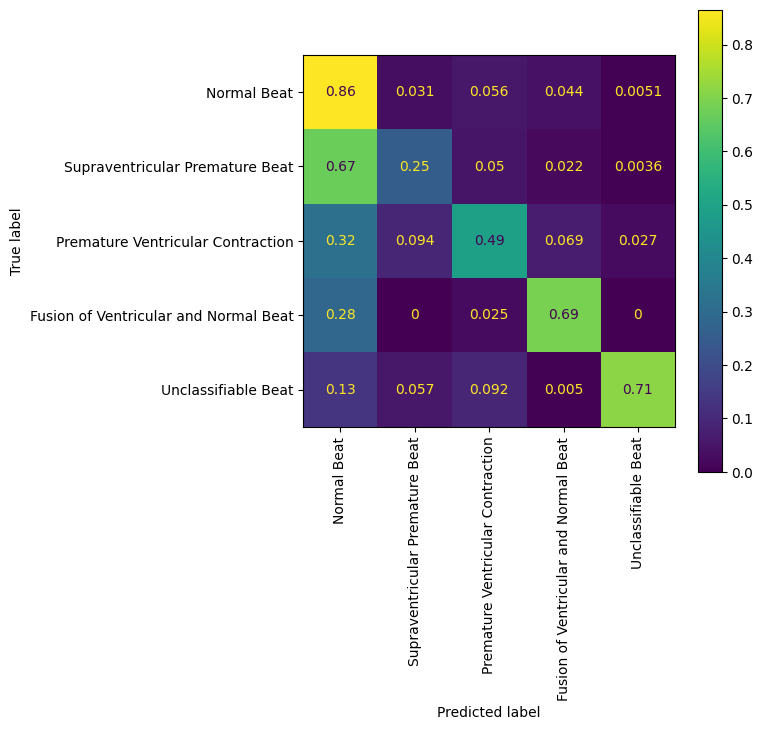

4.96074366569519 seconds


In [14]:
start_time = time.time()
model = LogisticRegression(multi_class = "multinomial", max_iter = 1000)
model.fit(Bcoef_train_minmax, y_train)
y_pred = model.predict(Bcoef_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

### K-Nearest Neighbors Classifier:

#### Without B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.99      0.97      0.98     18118
      Supraventricular Premature Beat       0.57      0.78      0.66       556
    Premature Ventricular Contraction       0.87      0.93      0.90      1448
Fusion of Ventricular and Normal Beat       0.60      0.77      0.68       162
                  Unclassifiable Beat       0.97      0.97      0.97      1608

                             accuracy                           0.96     21892
                            macro avg       0.80      0.88      0.84     21892
                         weighted avg       0.97      0.96      0.96     21892



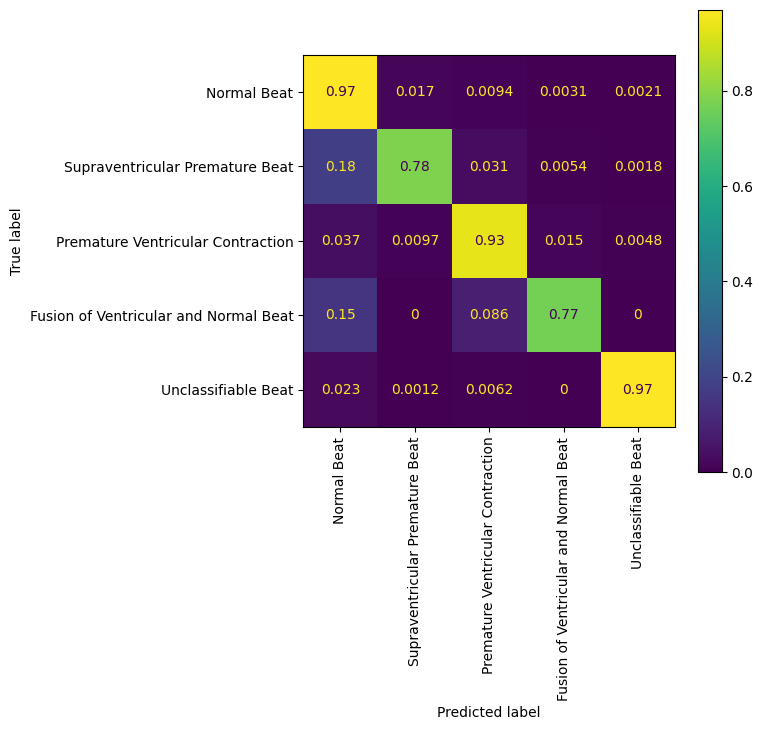

3.2293689250946045 seconds


In [15]:
start_time = time.time()
model = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
model.fit(X_train_minmax, y_train)
y_pred = model.predict(X_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

#### With B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.98      0.96      0.97     18118
      Supraventricular Premature Beat       0.44      0.69      0.53       556
    Premature Ventricular Contraction       0.84      0.90      0.87      1448
Fusion of Ventricular and Normal Beat       0.45      0.65      0.54       162
                  Unclassifiable Beat       0.95      0.92      0.93      1608

                             accuracy                           0.94     21892
                            macro avg       0.73      0.82      0.77     21892
                         weighted avg       0.95      0.94      0.94     21892



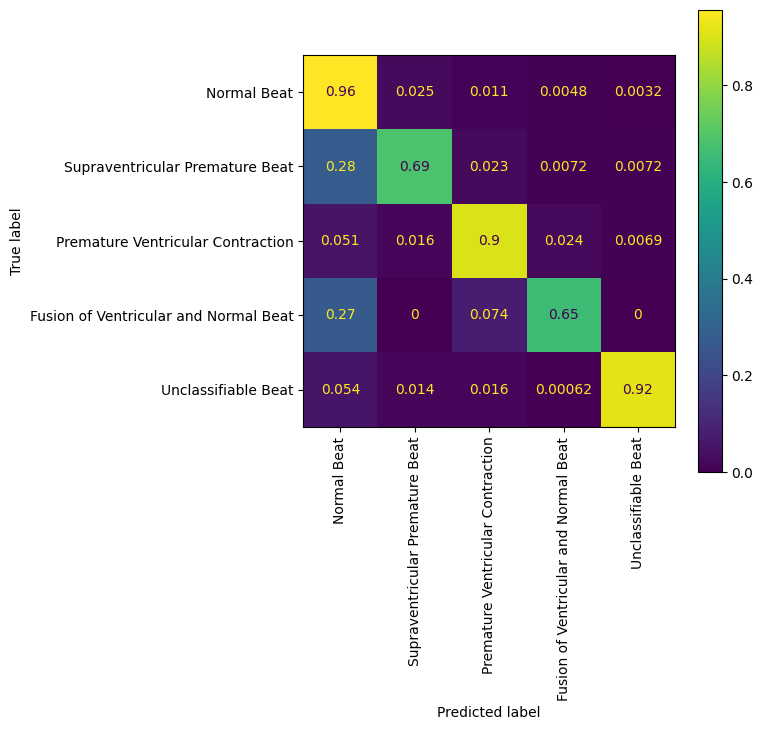

1.777007818222046 seconds


In [16]:
start_time = time.time()
model = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
model.fit(Bcoef_train_minmax, y_train)
y_pred = model.predict(Bcoef_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

### SVC:

#### Without B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.97      0.76      0.85     18118
      Supraventricular Premature Beat       0.24      0.63      0.35       556
    Premature Ventricular Contraction       0.44      0.83      0.58      1448
Fusion of Ventricular and Normal Beat       0.08      0.88      0.14       162
                  Unclassifiable Beat       0.86      0.89      0.87      1608

                             accuracy                           0.77     21892
                            macro avg       0.52      0.80      0.56     21892
                         weighted avg       0.90      0.77      0.82     21892



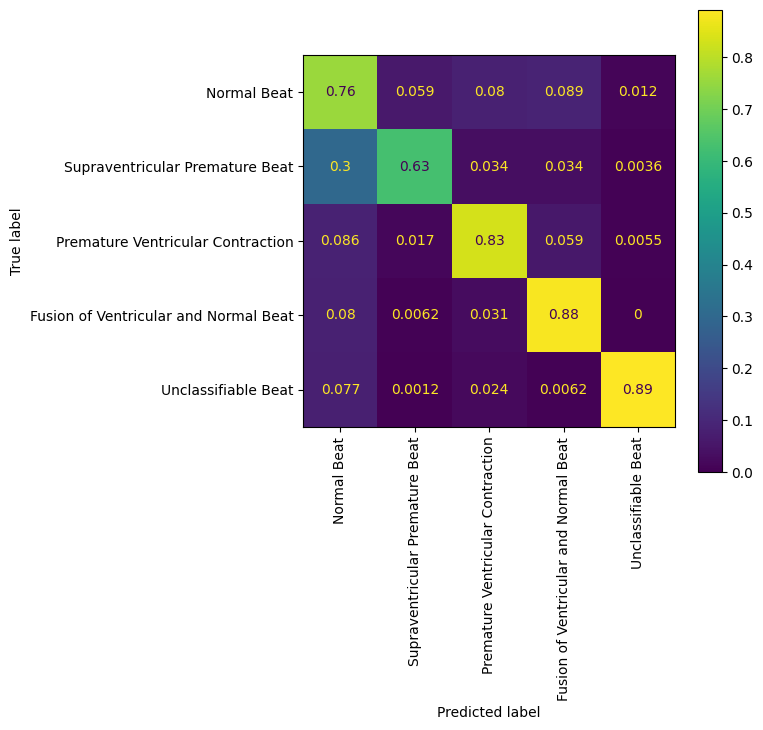

592.51691365242 seconds


In [17]:
start_time = time.time()
model = SVC(kernel = "rbf", gamma = "auto")
model.fit(X_train_minmax, y_train)
y_pred = model.predict(X_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

#### With B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.95      0.83      0.89     18118
      Supraventricular Premature Beat       0.18      0.56      0.28       556
    Premature Ventricular Contraction       0.46      0.55      0.50      1448
Fusion of Ventricular and Normal Beat       0.10      0.79      0.18       162
                  Unclassifiable Beat       0.92      0.81      0.86      1608

                             accuracy                           0.80     21892
                            macro avg       0.52      0.71      0.54     21892
                         weighted avg       0.89      0.80      0.84     21892



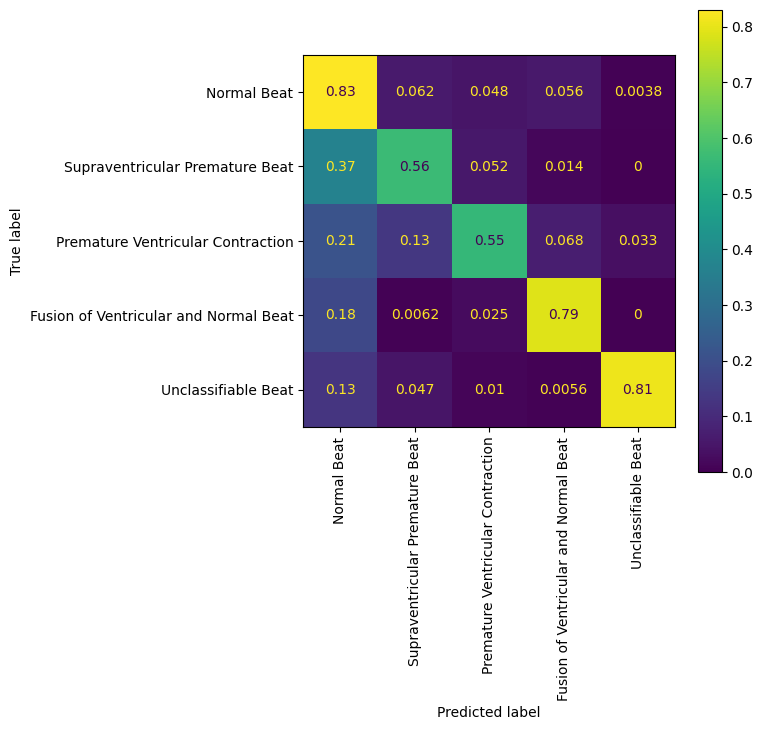

198.84546160697937 seconds


In [18]:
start_time = time.time()
model = SVC(kernel = "rbf", gamma = "auto")
model.fit(Bcoef_train_minmax, y_train)
y_pred = model.predict(Bcoef_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

### Naive Bayes Classifier:

#### Without B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.95      0.32      0.48     18118
      Supraventricular Premature Beat       0.09      0.14      0.11       556
    Premature Ventricular Contraction       0.17      0.23      0.20      1448
Fusion of Ventricular and Normal Beat       0.03      0.95      0.06       162
                  Unclassifiable Beat       0.20      0.97      0.33      1608

                             accuracy                           0.36     21892
                            macro avg       0.29      0.52      0.23     21892
                         weighted avg       0.81      0.36      0.44     21892



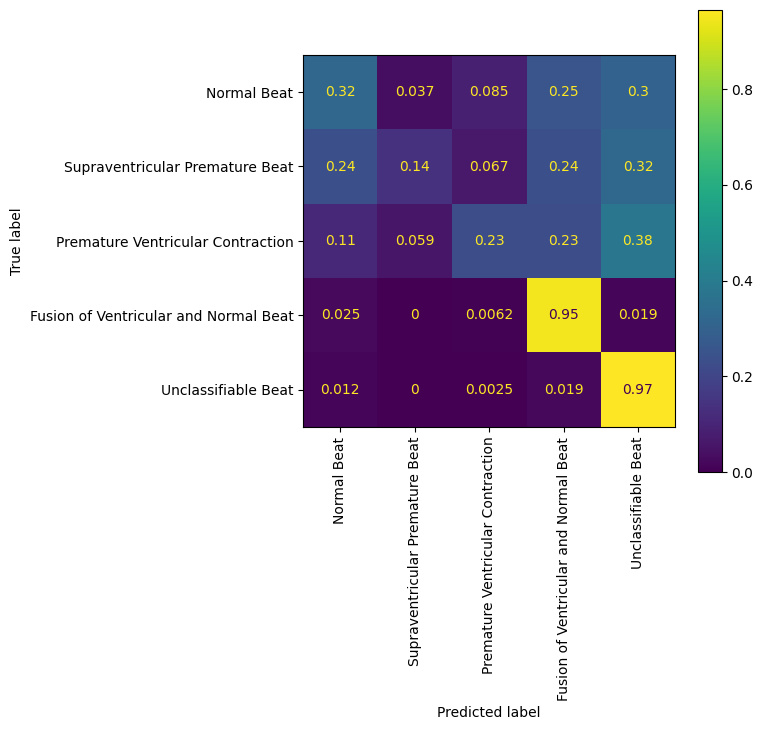

20.111155033111572 seconds


In [19]:
start_time = time.time()
model = MultinomialNB()
parameters = {"alpha": np.arange(0.1, 1, 0.01)}
grid = GridSearchCV(model, parameters, n_jobs = -1)
grid.fit(X_train_minmax, y_train)
model = grid.best_estimator_.fit(X_train_minmax, y_train)
model.fit(X_train_minmax, y_train)
y_pred = model.predict(X_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

#### With B-Spline:

                                       precision    recall  f1-score   support

                          Normal Beat       0.94      0.74      0.83     18118
      Supraventricular Premature Beat       0.18      0.54      0.27       556
    Premature Ventricular Contraction       0.29      0.33      0.31      1448
Fusion of Ventricular and Normal Beat       0.05      0.85      0.10       162
                  Unclassifiable Beat       0.63      0.71      0.67      1608

                             accuracy                           0.71     21892
                            macro avg       0.42      0.63      0.44     21892
                         weighted avg       0.85      0.71      0.76     21892



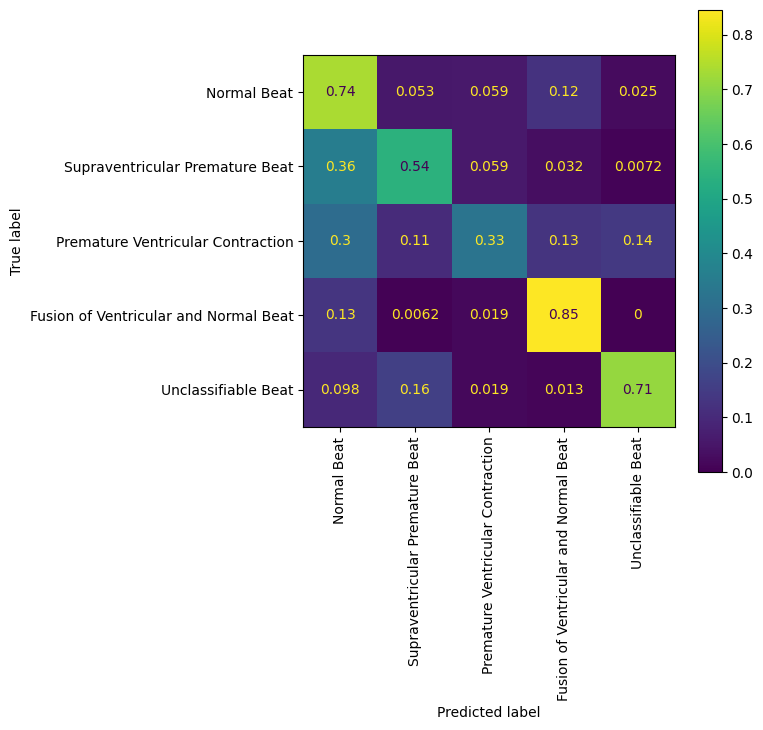

2.794551372528076 seconds


In [20]:
start_time = time.time()
model = MultinomialNB()
parameters = {"alpha": np.arange(0.1, 1, 0.01)}
grid = GridSearchCV(model, parameters, n_jobs = -1)
grid.fit(Bcoef_train_minmax, y_train)
model = grid.best_estimator_.fit(Bcoef_train_minmax, y_train)
y_pred = model.predict(Bcoef_test_minmax)
print(classification_report(y_test, y_pred, target_names = class_names))

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names, ax = ax, normalize = "true")
plt.xticks(rotation = 90)
plt.show()
print(f"{(time.time() - start_time)} seconds")

## Results:

K-Nearest Neighbors Classifier seems to work best across all tested models. Using b-splines, does not improve  results for KNN. 

SVC does not improve significantly with b-splines. However, using b-spline reduces computation time by near 50%.

Naive Bayes and Logistic Regression improves significantly with b-splines.